# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Необходимо построить модель с предельно большим значением F1-меры. Нужно довести метрику до 0.59. Проверить F1-меру на тестовой выборке.

Дополнительно надо измерять AUC-ROC, сравнивать её значение с F1-мерой.

### Цель исследования

- Необходимо построить модель с предельно большим значением F1-меры, которая будет предсказывать, уйдет ли клиент. - Довести метрику до 0.59. 
- Проверить F1-меру на тестовой выборке.
- Измерять AUC-ROC, сравнивать её значение с F1-мерой.

### Описание данных

<b>Признаки</b>
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

<b>Целевой признак</b>
- Exited — факт ухода клиента

<b>Ход исследования</b>

Оптимально провести исследование по следующему плану:

- Подготовка данных. 
- Исследование баланса классов, обучение модели без учёта дисбаланса.
- Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
- Провести финальное тестирование.

## Подготовка данных.

Для начала лучше импортировать все необходимые библиотеки для работы:

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 

#модуль для разделения выборки
from sklearn.model_selection import train_test_split

#библиотека для стандартноо масштабирования
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

#Деревое решений
from sklearn.tree import DecisionTreeClassifier

#Случайный лес 
from sklearn.ensemble import RandomForestClassifier

#Логистическая регрессия
from sklearn.linear_model import LogisticRegression

#метрика accuracy
from sklearn.metrics import accuracy_score

#матрица ошибок
from sklearn.metrics import confusion_matrix

#полнота
from sklearn.metrics import recall_score

#точность
from sklearn.metrics import precision_score

#F-1 мера
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC-кривая
from sklearn.metrics import roc_curve

#модуль для последовательного перемешивания массивов
from sklearn.utils import shuffle

#метод для перебора нескольких параметров
from itertools import product

#ROC-кривая
from sklearn.metrics import roc_curve

Загрузим данные и изучим их:

In [175]:
try:
    df = pd.read_csv('/Users/vladislav/Documents/datasets//Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [176]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [177]:
df.columns = map(str.lower, df.columns)

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заполним пропуски:

In [179]:
df['tenure'] = df['tenure'].fillna(-1)

In [180]:
def make_pie_plot(data, name):
    counts = data.value_counts()
    counts.plot.pie(legend=True, labeldistance=1.2, autopct='%1.2f%%', figsize=(12,6), title=name)
    plt.show()

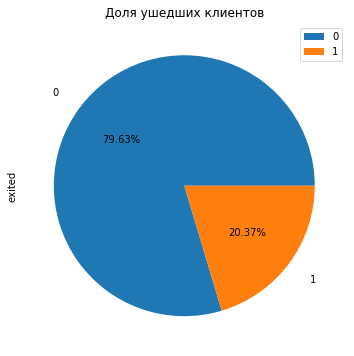

In [181]:
make_pie_plot(df['exited'], 'Доля ушедших клиентов')
# 1 = Да, 0 = Нет

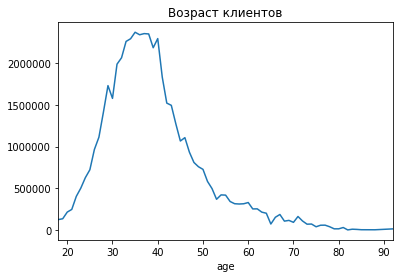

In [182]:
df.pivot_table(index='age', values='rownumber', aggfunc='sum').sort_values('age', ascending=False).plot(legend=False, title='Возраст клиентов')
plt.show()

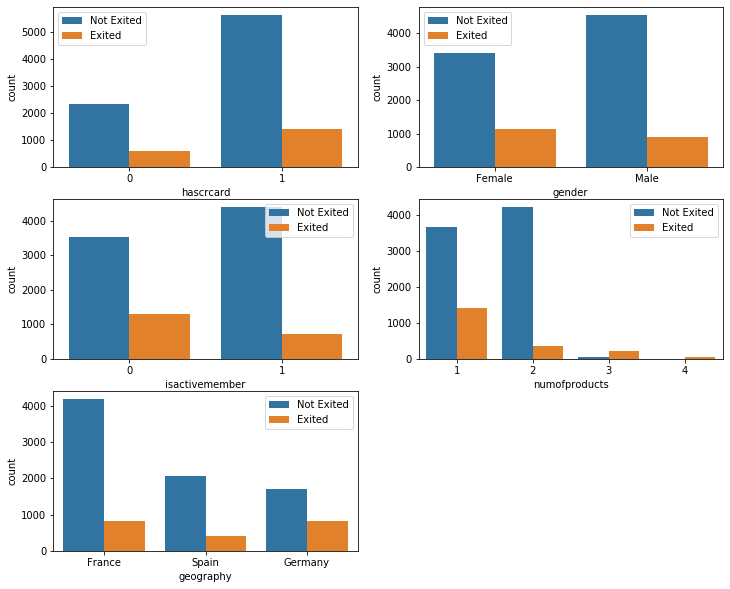

In [183]:
plt.figure(figsize=(12,10))
columns = ['hascrcard', 'gender', 'isactivemember', 'numofproducts', 'geography']
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=columns[i], hue='exited', data=df)
    plt.xticks(rotation=0)
    plt.legend(["Not Exited", "Exited"])
plt.show()

Датасет содержит 10000 строк, явных пропусков не обнаружено.
Требуемые изменения:

RowNumber — столбец дублирует информацию стандартного датафрейма и не несетя ценности для обучения модели. Поэтому столбец можно удалить

CustomerId — является идентификатором пользователя (по данному столбцу значению необходимо проверить наличие дубликатов) и если отсутсвуют — стоблец также можно удалить.

Surname — является идентифицирующей пользователя информацией, но не несет ценности для качества будущей модели — столбец можно удалить.

CreditScore — следует сохранить данный столбец.

Geography — всего 3 уникальных значения France', 'Spain', 'Germany' — выполнить преобразование OHE / ordinal encoding

Gender — значение преобразовать — OHE / ordinal encoding.

Age — Exited — тип данных верны, требуется проработка OHE.

Уберем ненужные столбцы. Обозначим target и features с помощью функции

In [184]:
df = df.drop(['rownumber','customerid','surname'], axis=1)
rnd_state = 12345

In [185]:
def make_target_features(data, target_col='exited'):    
    target = data[target_col]
    features = data.drop(target_col, axis=1)
    return target, features

Поделим исходный набор данных на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов сделаем 60% \ 20% \ 20%

In [186]:
def split_data(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.6, random_state=rnd_state)

    features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=rnd_state)
    # Масштабируем количественные признаки
    scaler = StandardScaler()
    numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

Функция возвращает обученную модель

In [187]:
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    target, features = make_target_features(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1 of valid: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1 of test: {f1_score(target_test, predicted_test)}')
        
    
    return model

Преобразуем категориальные признаки в численные

In [188]:
data_ohe = pd.get_dummies(df, drop_first=True)

## Исследование баланса классов, обучение модель без учёта дисбаланса.

Проверим, как часто в целевом признаке нашего исходного датасета встречается класс «1» или «0»:

In [189]:
frequency_of_0_1 = df['exited'].value_counts(normalize=True)
frequency_of_0_1

0    0.7963
1    0.2037
Name: exited, dtype: float64

Соотношение не сбалансировано: отрицательных ~ 80% и положительных ~ 20%. На данном этапе мы будем исследовать модели без учета дисбаланса классов, заведомо ожидая плохие результаты.

Часть данных - категориальные. Для обучения модели логистической регрессии нам потребуется преобразовать категориальные признаки прямым кодированием, а для обучения модели решающего дерева или случайного леса выполнить порядковое кодирование. Применим технику порядкового кодирования для категориальных признаков.

In [190]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [191]:
encoder = OrdinalEncoder()
data_ordinal = df
data_ordinal[['geography','gender']] = encoder.fit_transform(data_ordinal[['geography','gender']])
data_ordinal.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0


### Логистическая регрессия

In [192]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1 of valid: 0.32941176470588235


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Плохие показатели F1 при дисбалансе данных

### Decision Tree Classifier

In [193]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.5095057034220531
max_depth 4:	F1 of valid: 0.494773519163763
max_depth 6:	F1 of valid: 0.5178571428571429
max_depth 8:	F1 of valid: 0.5317220543806646
max_depth 10:	F1 of valid: 0.5132223310479921
max_depth 12:	F1 of valid: 0.4790419161676647
max_depth 14:	F1 of valid: 0.49228269699431354
max_depth 16:	F1 of valid: 0.4873417721518988
max_depth 18:	F1 of valid: 0.4792993630573248
max_depth 20:	F1 of valid: 0.4854673998428908


Лучший показатель при глубине 8: max_depth 4: F1 of valid: 0.5317220543806646

### Random Forest Classifier

In [194]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=4, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.5017341040462427
n_estimators = 20:	F1 of valid: 0.4520048602673147
n_estimators = 30:	F1 of valid: 0.45232273838630804
n_estimators = 40:	F1 of valid: 0.4611650485436894
n_estimators = 50:	F1 of valid: 0.4452644526445264
n_estimators = 60:	F1 of valid: 0.44499381953028433
n_estimators = 70:	F1 of valid: 0.44389642416769426
n_estimators = 80:	F1 of valid: 0.45797807551766134
n_estimators = 90:	F1 of valid: 0.44963144963144963
n_estimators = 100:	F1 of valid: 0.44389642416769426
n_estimators = 110:	F1 of valid: 0.4367245657568239
n_estimators = 120:	F1 of valid: 0.44554455445544555
n_estimators = 130:	F1 of valid: 0.42999999999999994
n_estimators = 140:	F1 of valid: 0.44139650872817954
n_estimators = 150:	F1 of valid: 0.44801980198019803
n_estimators = 160:	F1 of valid: 0.45297029702970304
n_estimators = 170:	F1 of valid: 0.4507389162561577
n_estimators = 180:	F1 of valid: 0.44857496902106564
n_estimators = 190:	F1 of valid: 0.45185185185185184
n_estima

Лучший результат при количестве деревьев 10: n_estimators = 10: F1 of valid: 0.5017341040462427

## Улучшение качества модели, учитывая дисбаланс классов

Придадим объектам редкого класса 1 больший вес используя гиперпараметр class_weight='balanced'

### Взвешивание классов

#### Логистическая регрессия

In [195]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1 of valid: 0.48023255813953497


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Результат немного лучше чем с несбалансированнными данными

#### Decision Tree Classifier

In [196]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.48306010928961746
max_depth 4:	F1 of valid: 0.532133676092545
max_depth 6:	F1 of valid: 0.5494505494505495
max_depth 8:	F1 of valid: 0.503287507471608
max_depth 10:	F1 of valid: 0.489589905362776
max_depth 12:	F1 of valid: 0.4875690607734806
max_depth 14:	F1 of valid: 0.4834834834834834
max_depth 16:	F1 of valid: 0.4740973312401884
max_depth 18:	F1 of valid: 0.4777070063694267
max_depth 20:	F1 of valid: 0.475423045930701


Лучший результат с глубиной в 6: max_depth 6: F1 of valid: 0.5494505494505495

#### Random Forest Classifier

In [197]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.5748251748251748
n_estimators = 20:	F1 of valid: 0.5834502103786817
n_estimators = 30:	F1 of valid: 0.5953878406708596
n_estimators = 40:	F1 of valid: 0.5946704067321178
n_estimators = 50:	F1 of valid: 0.5876645876645876
n_estimators = 60:	F1 of valid: 0.5884802220680083
n_estimators = 70:	F1 of valid: 0.5902777777777778
n_estimators = 80:	F1 of valid: 0.5929509329647548
n_estimators = 90:	F1 of valid: 0.5894448252227553
n_estimators = 100:	F1 of valid: 0.5892002734107997
n_estimators = 110:	F1 of valid: 0.5897610921501706
n_estimators = 120:	F1 of valid: 0.5863013698630136
n_estimators = 130:	F1 of valid: 0.5887207702888584
n_estimators = 140:	F1 of valid: 0.5900962861072901
n_estimators = 150:	F1 of valid: 0.59500693481276
n_estimators = 160:	F1 of valid: 0.5954198473282443
n_estimators = 170:	F1 of valid: 0.5962473940236276
n_estimators = 180:	F1 of valid: 0.5959525471039776
n_estimators = 190:	F1 of valid: 0.5952712100139081
n_estimators = 200:	F1 

Лучший результат с количиством деревьем 170: n_estimators = 170: F1 of valid: 0.5962473940236276

### Увеличение выборки

Увеличим объекты редкого класса и переобучим модели.



In [198]:
def upsample(features, target, repeat=4):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

#### Логистическая регрессия

In [199]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1 of valid: 0.4772599663110612


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

#### Decision Tree Classifier

In [200]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.48306010928961746
max_depth 4:	F1 of valid: 0.48651399491094155
max_depth 6:	F1 of valid: 0.5473145780051151
max_depth 8:	F1 of valid: 0.5002985074626867
max_depth 10:	F1 of valid: 0.48557089084065247
max_depth 12:	F1 of valid: 0.4986449864498645
max_depth 14:	F1 of valid: 0.4766146993318486
max_depth 16:	F1 of valid: 0.4798136645962732
max_depth 18:	F1 of valid: 0.49005568814638023
max_depth 20:	F1 of valid: 0.4768856447688565


Лучший результат с глубиной 6: max_depth 6: F1 of valid: 0.5473145780051151

#### Random Forest Classifier

In [201]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.54351909830933
n_estimators = 20:	F1 of valid: 0.5656050955414013
n_estimators = 30:	F1 of valid: 0.5652173913043478
n_estimators = 40:	F1 of valid: 0.5682989690721649
n_estimators = 50:	F1 of valid: 0.5692208628461043
n_estimators = 60:	F1 of valid: 0.5681233933161953
n_estimators = 70:	F1 of valid: 0.5694267515923567
n_estimators = 80:	F1 of valid: 0.5681674064679773
n_estimators = 90:	F1 of valid: 0.5745222929936306
n_estimators = 100:	F1 of valid: 0.5736040609137056
n_estimators = 110:	F1 of valid: 0.5743329097839899
n_estimators = 120:	F1 of valid: 0.5721551176096631
n_estimators = 130:	F1 of valid: 0.5730622617534942
n_estimators = 140:	F1 of valid: 0.5734355044699873
n_estimators = 150:	F1 of valid: 0.5738019169329074
n_estimators = 160:	F1 of valid: 0.5738019169329074
n_estimators = 170:	F1 of valid: 0.5749039692701665
n_estimators = 180:	F1 of valid: 0.5732565579014716
n_estimators = 190:	F1 of valid: 0.5743589743589744
n_estimators = 200:	F1 

Лучший результат с количеством деревьев 90: n_estimators = 90: F1 of valid: 0.5745222929936306

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов

Уменьшеним выборку

### Уменьшение выборки

In [202]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

#### Логистическая регрессия

In [203]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1 of valid: 0.46421471172962225


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

#### DecisionTreeClassifier

In [204]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1 of valid: 0.5234270414993307
max_depth 4:	F1 of valid: 0.4926160337552743
max_depth 6:	F1 of valid: 0.5134670487106018
max_depth 8:	F1 of valid: 0.48527048741296197
max_depth 10:	F1 of valid: 0.45963401506996776
max_depth 12:	F1 of valid: 0.46336206896551724
max_depth 14:	F1 of valid: 0.46203904555314534
max_depth 16:	F1 of valid: 0.4548892490545651
max_depth 18:	F1 of valid: 0.4548892490545651
max_depth 20:	F1 of valid: 0.4548892490545651


Лучший результат при глубине 2: max_depth 2: F1 of valid: 0.5234270414993307

#### RandomForestClassifier

In [205]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=2, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1 of valid: 0.4738292011019284
n_estimators = 20:	F1 of valid: 0.4797421731123388
n_estimators = 30:	F1 of valid: 0.4724199288256227
n_estimators = 40:	F1 of valid: 0.4704821991888238
n_estimators = 50:	F1 of valid: 0.46488888888888885
n_estimators = 60:	F1 of valid: 0.456369982547993
n_estimators = 70:	F1 of valid: 0.4609306409130816
n_estimators = 80:	F1 of valid: 0.46457399103139013
n_estimators = 90:	F1 of valid: 0.46275197195442597
n_estimators = 100:	F1 of valid: 0.4556521739130435
n_estimators = 110:	F1 of valid: 0.45529157667386605
n_estimators = 120:	F1 of valid: 0.46167323696890056
n_estimators = 130:	F1 of valid: 0.457117979973879
n_estimators = 140:	F1 of valid: 0.4556852572416775
n_estimators = 150:	F1 of valid: 0.4619445666520018
n_estimators = 160:	F1 of valid: 0.46490835940992403
n_estimators = 170:	F1 of valid: 0.46256092157731504
n_estimators = 180:	F1 of valid: 0.4601769911504425
n_estimators = 190:	F1 of valid: 0.4663960306720793
n_estimators = 2

Лучший результат при количестве деревьев 20: n_estimators = 60: F1 of valid: 0.4797421731123388

Значение F1-меры у каждой из рассмотренных моделей меньше, чем в случае балансировки классов. В случае Decision Tree Classifier разница мала.

### Вывод по результатам исследования

В первоначальных данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными). Все модели не первоначальных данных характеризовались низким качеством взвешенной величины (F1).

Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классов в обучеющей выборки.

На новых данных все модели показали результат выше, чем на несбалансированной выборке. 

Было принято решение продолжать улучшение модели на основании алгоритма случайный лес (RandomForestClassifier)

Улучшение модели происходило путем цикла выбора гиперпараметров, которые показывали наиболее высокое значение F1 меры и не приводили модель к переобучению. 

Финальные параметры выбранной модели RandomForestClassifier(n_estimators = 170, random_state=12345).
Результаты модели:
F1-мера 0.5962473940236276

## Тестирование модели

Лучший результат показала модель Random Forest Classifier с глубиной 6 и количеством деревьев 170

In [210]:
target, features = make_target_features(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=170, max_depth=6, random_state=rnd_state)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.5962473940236276
test: 0.5958333333333332


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели

In [211]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8524830977432554

In [212]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.8525304791363608

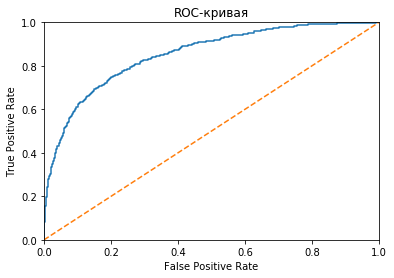

In [213]:
final_model_probabilities_one = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Финальная модель достигла заданой метрики (F1 > 0.59) и показывает адекватные результаты, поэтому она с высокой вероятностью предскажит уход клиента из банка.

## Общий вывод

Рассматривая данные с учетом дисбаланса + переведенные категориальные + стандартизированные данные и без учета дисбаланса тремя моделями можно сделать вывод, что самая лучшая модель оказалась Случайный лес. При лучшем значении max_depth=6,n_estimators=170, мы имеем F1 меру =0,596 на тестовой(валидной) выборке. Хуже всего себя показала модель Логистическая регрессия